In [4]:
#importing required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [22]:
import warnings
warnings.filterwarnings('ignore')

## Step 1: Reading and understanding the data

In [5]:
bikeSharing = pd.read_csv("day.csv")

In [6]:
bikeSharing.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [13]:
# Renaming few columns for better readability
bikeSharing.rename(columns={'yr':'year','mnth':'month','hum':'humidity'}, inplace=True)

In [7]:
bikeSharing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [8]:
bikeSharing.shape

(730, 16)

In [9]:
bikeSharing.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [10]:
#Check for missing values
bikeSharing.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

#### We can see that no missing values

In [11]:
#Now remove duplicates
bikeSharing = bikeSharing.drop_duplicates()
bikeSharing.shape

(730, 16)

#### Shape didn't change, so no duplicates in the dataset

In [12]:
# Dropping columns that are not needed
bikeSharing.drop(['instant','dteday','casual','registered'],axis=1,inplace=True)
# Instant is a primary key column which is not useful for analysis
# dteday can be calculate from year, month
# casual and registered are breakup of our target column cnt. But we dont need the breakup

In [14]:
# convert the numerical values to categorical values in season, month, weekday, weathersit
bikeSharing['season'] = bikeSharing['season'].map({1:'spring', 2:'summer', 3:'fall', 4:'winter'})
bikeSharing['month'] = bikeSharing['month'].map({1:'jan',2:'feb',3:'mar',4:'apr',5:'may',6:'june',7:'july',8:'aug',9:'sep',10:'oct',11:'nov',12:'dec'})
bikeSharing['weekday'] = bikeSharing['weekday'].map({0:'sun',1:'mon',2:'tue',3:'wed',4:'thu',5:'fri',6:'sat'})
bikeSharing['weathersit'] = bikeSharing['weathersit'].map({1:'Clear',2:'Mist',3:'Light_snow_rain',4:'Heavy_snow_rain'})

In [16]:
bikeSharing.head()

,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,cnt
0,spring,0,jan,0,sat,0,Mist,14.110847,18.18125,80.5833,10.749882,985
1,spring,0,jan,0,sun,0,Mist,14.902598,17.68695,69.6087,16.652113,801
2,spring,0,jan,0,mon,1,Clear,8.050924,9.47025,43.7273,16.636703,1349
3,spring,0,jan,0,tue,1,Clear,8.200000,10.60610,59.0435,10.739832,1562
4,spring,0,jan,0,wed,1,Clear,9.305237,11.46350,43.6957,12.522300,1600


## Step 2: Data Visualization

<Figure size 1200x800 with 0 Axes>

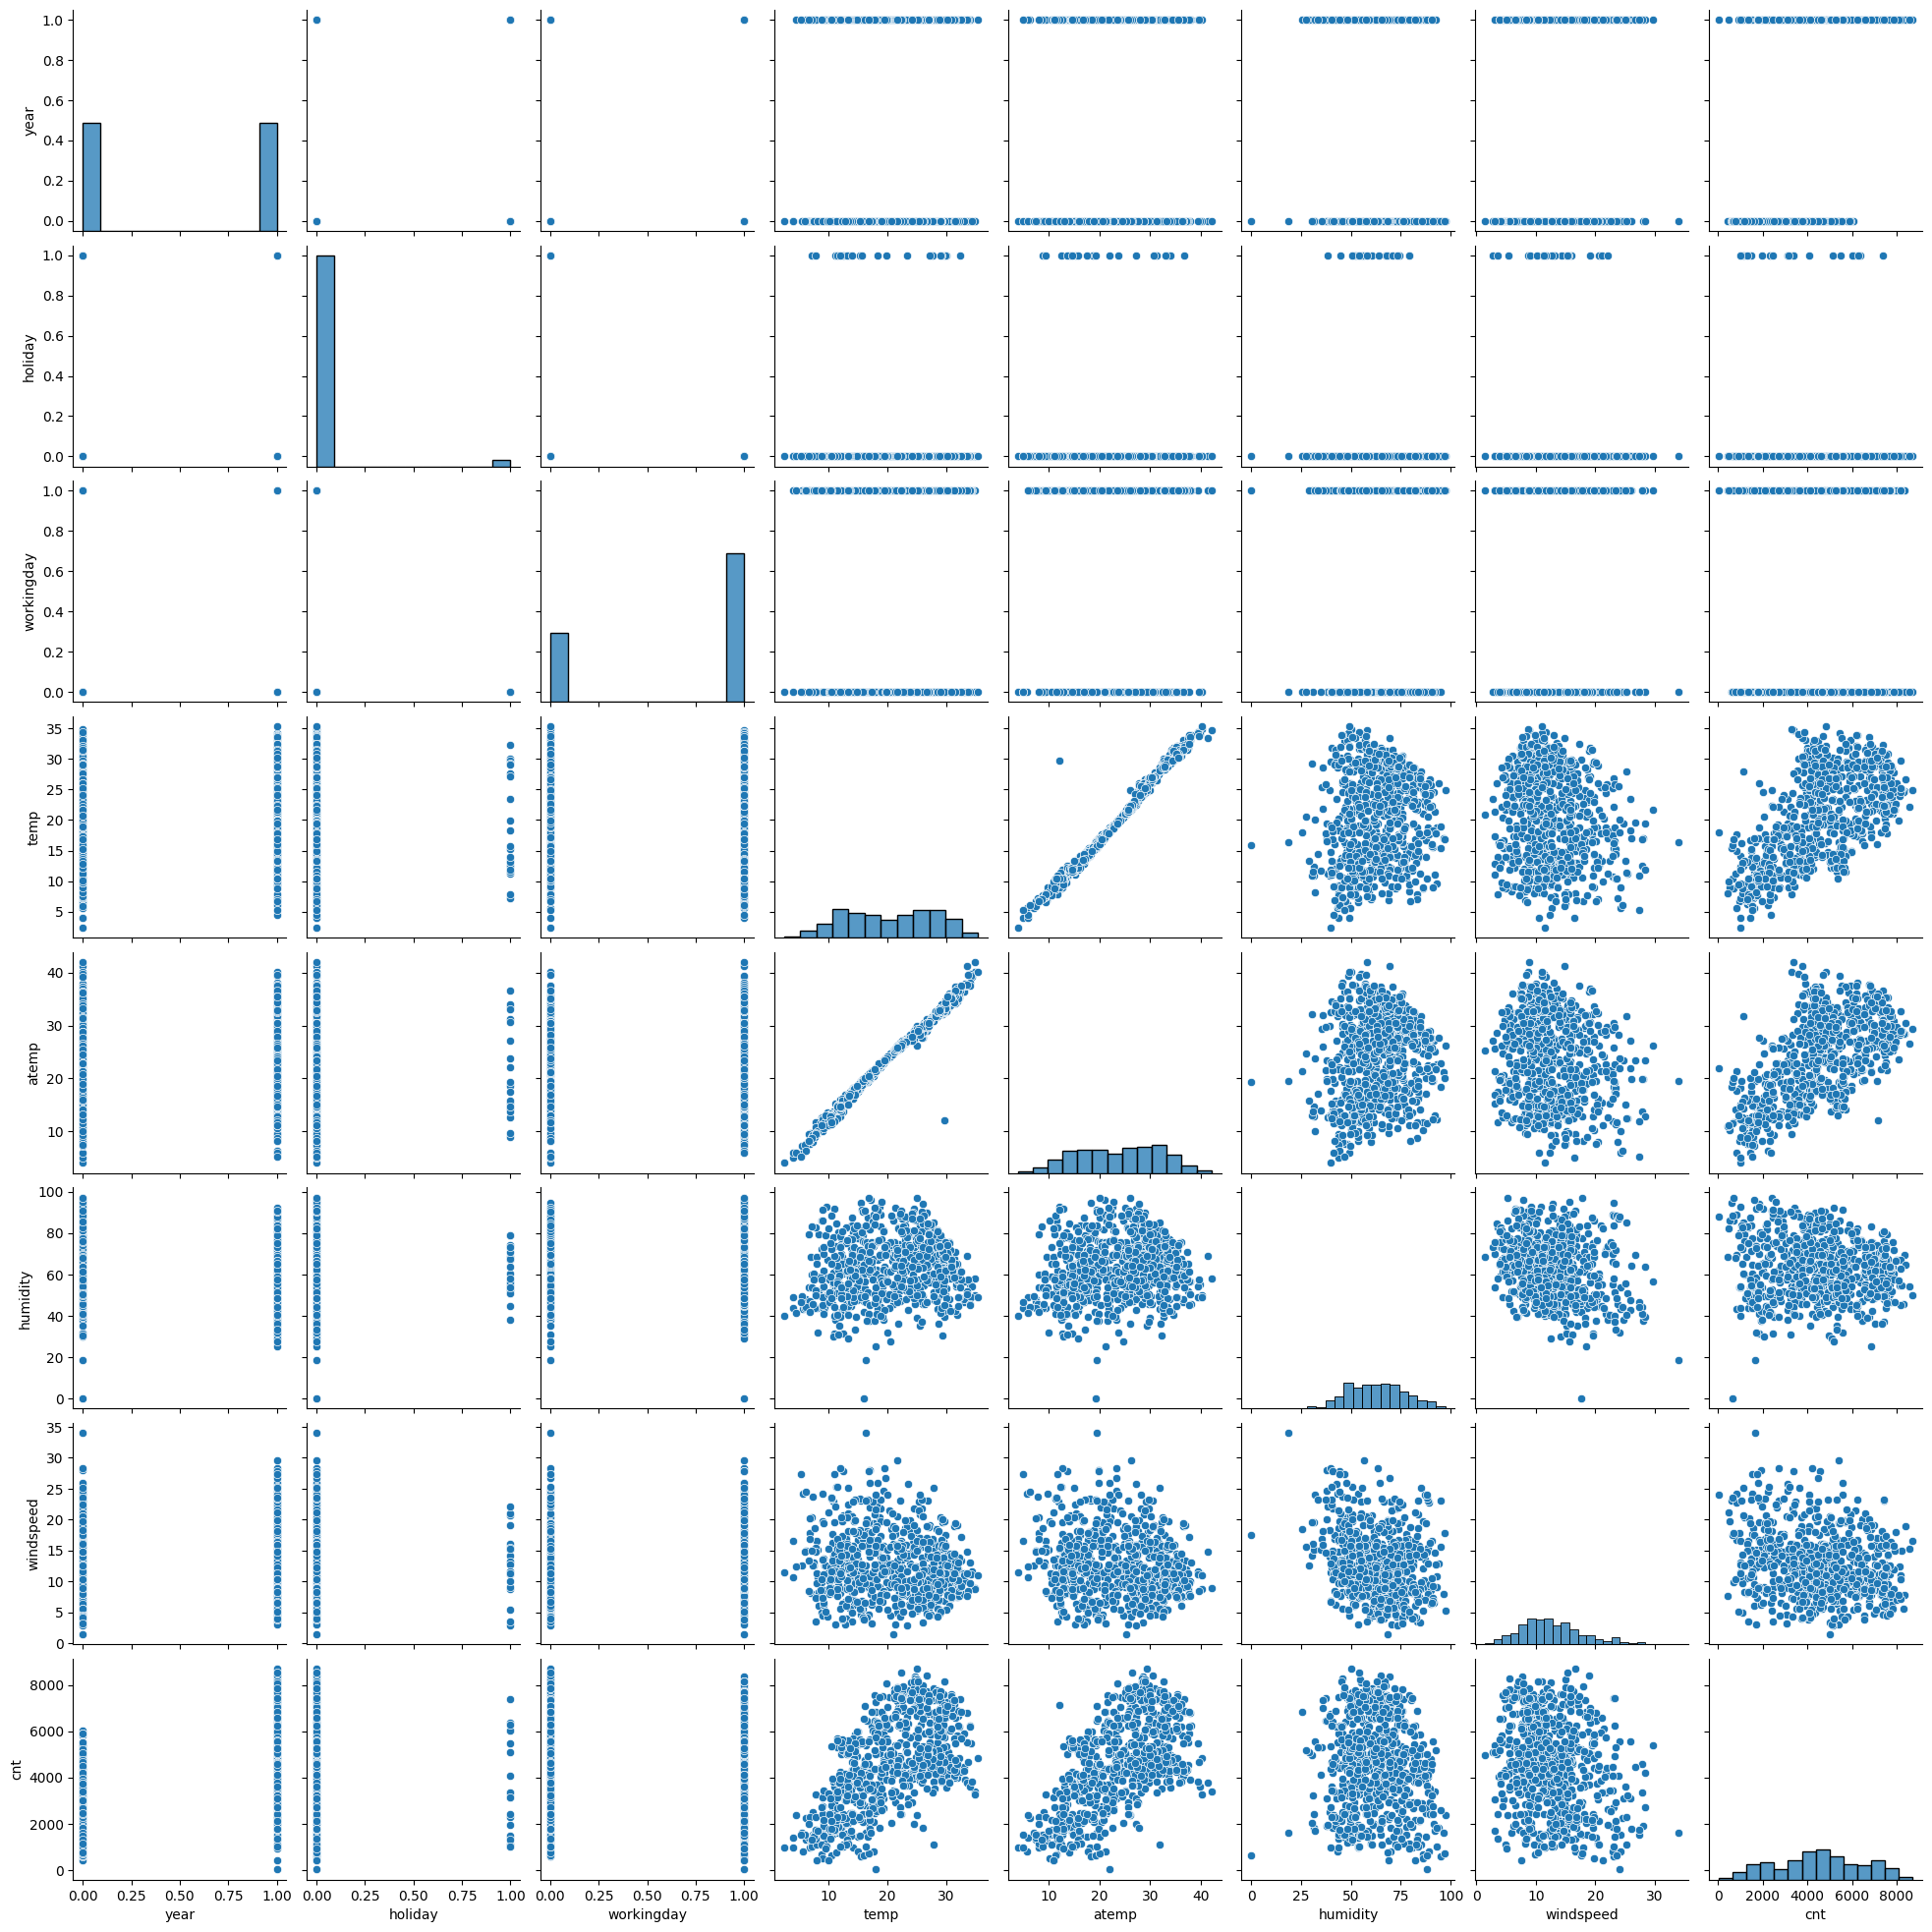

In [19]:
plt.figure(figsize = (12, 8))
sns.pairplot(bikeSharing)
plt.show()

<Axes: >

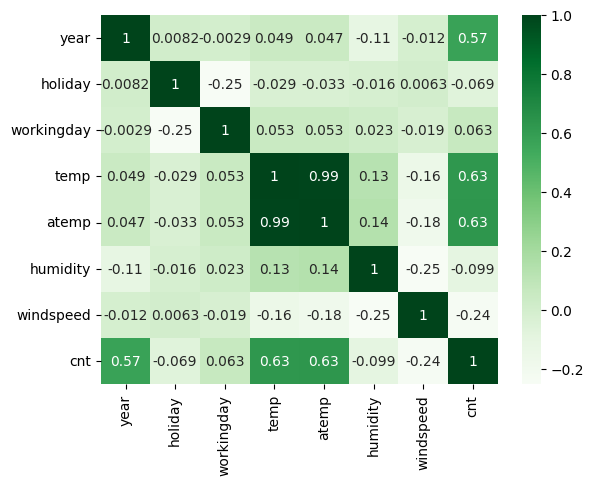

In [23]:
sns.heatmap(bikeSharing.corr(),cmap="Greens",annot=True)

### Observations
1) temp and atemp are independent variable with which cnt has linear relationship
2) temp and atemp are highly correlated

## Categorical variables

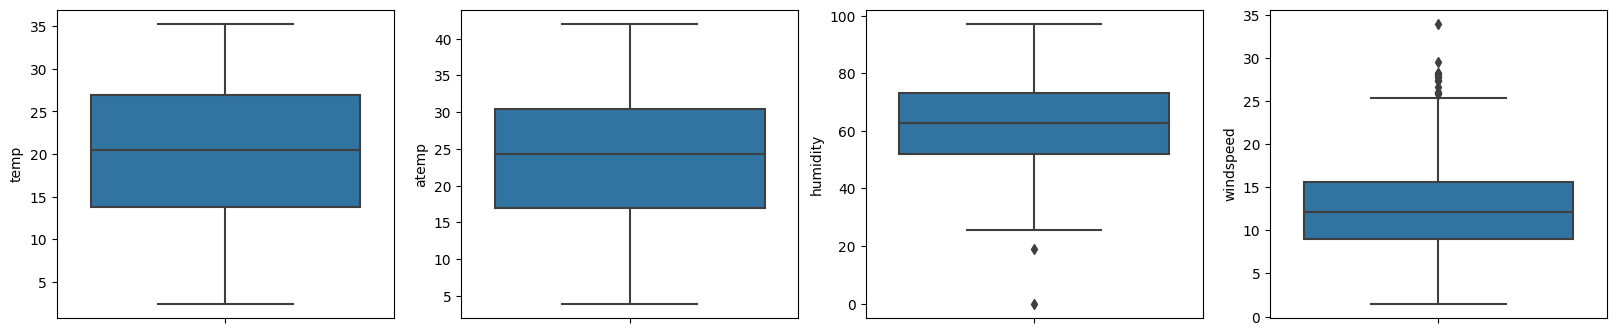

In [24]:
cato_cols = ['temp', 'atemp', 'humidity', 'windspeed']
plt.figure(figsize=(20,4))

i = 1
for col in cato_cols:
    plt.subplot(1,4,i)
    sns.boxplot(y=col, data=bikeSharing)
    i+=1

### Observations
Data looks good, no outlier treatment needed

## Step 3: Data Preparation

### Creating dummy variables

In [26]:
# Get the dummy variables for the categorical variables 'season','mnth','weekday','weathersit'
dummy = bikeSharing[['season','month','weekday','weathersit']]
dummy = pd.get_dummies(dummy,drop_first=True)
dummy.head()

,season_spring,season_summer,season_winter,month_aug,month_dec,month_feb,month_jan,month_july,month_june,month_mar,month_may,month_nov,month_oct,month_sep,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,weathersit_Light_snow_rain,weathersit_Mist
0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [27]:
### Adding these dummy variables into original df
bikeSharing = pd.concat([bikeSharing,dummy],axis = 1)
bikeSharing.head()

,season,year,month,holiday,weekday,workingday,weathersit,temp,atemp,humidity,windspeed,cnt,season_spring,season_summer,season_winter,month_aug,month_dec,month_feb,month_jan,month_july,month_june,month_mar,month_may,month_nov,month_oct,month_sep,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,weathersit_Light_snow_rain,weathersit_Mist
0,spring,0,jan,0,sat,0,Mist,14.110847,18.18125,80.5833,10.749882,985,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
1,spring,0,jan,0,sun,0,Mist,14.902598,17.68695,69.6087,16.652113,801,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
2,spring,0,jan,0,mon,1,Clear,8.050924,9.47025,43.7273,16.636703,1349,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,spring,0,jan,0,tue,1,Clear,8.200000,10.60610,59.0435,10.739832,1562,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
4,spring,0,jan,0,wed,1,Clear,9.305237,11.46350,43.6957,12.522300,1600,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [30]:
# Dropping original categorical columns
bikeSharing.drop(['season','month','weekday','weathersit'],axis = 1,inplace=True)

In [31]:
bikeSharing.shape

(730, 30)

## Step 4: Splitting into train and test data

In [32]:
#splitting the data into 70% train data and 30% test data
train, test = train_test_split(bikeSharing, train_size = 0.7, random_state = 100)

In [33]:
train.shape

(510, 30)

In [34]:
test.shape

(220, 30)

## Step 5: Rescaling the features

In [35]:
# We will be using min-max scaling here
scaler = MinMaxScaler()

In [36]:
scale_features = ['cnt','humidity','windspeed','temp','atemp']

train[scale_features] = scaler.fit_transform(train[scale_features])

In [37]:
train.head()

,year,holiday,workingday,temp,atemp,humidity,windspeed,cnt,season_spring,season_summer,season_winter,month_aug,month_dec,month_feb,month_jan,month_july,month_june,month_mar,month_may,month_nov,month_oct,month_sep,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,weathersit_Light_snow_rain,weathersit_Mist
576,1,0,1,0.815169,0.766351,0.725633,0.264686,0.827658,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
426,1,0,0,0.442393,0.438975,0.640189,0.255342,0.465255,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1
728,1,0,0,0.245101,0.200348,0.498067,0.663106,0.204096,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
482,1,0,0,0.395666,0.391735,0.504508,0.188475,0.482973,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
111,0,0,1,0.345824,0.318819,0.751824,0.380981,0.191095,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [38]:
train.describe()

,year,holiday,workingday,temp,atemp,humidity,windspeed,cnt,season_spring,season_summer,season_winter,month_aug,month_dec,month_feb,month_jan,month_july,month_june,month_mar,month_may,month_nov,month_oct,month_sep,weekday_mon,weekday_sat,weekday_sun,weekday_thu,weekday_tue,weekday_wed,weathersit_Light_snow_rain,weathersit_Mist
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.676471,0.537440,0.513156,0.650480,0.320883,0.513499,0.243137,0.247059,0.247059,0.096078,0.084314,0.066667,0.088235,0.076471,0.076471,0.098039,0.084314,0.086275,0.084314,0.080392,0.150980,0.154902,0.143137,0.133333,0.131373,0.158824,0.029412,0.345098
std,0.500429,0.157763,0.468282,0.225858,0.212410,0.145846,0.169803,0.224421,0.429398,0.431725,0.431725,0.294988,0.278131,0.249689,0.283915,0.266010,0.266010,0.297660,0.278131,0.281045,0.278131,0.272166,0.358381,0.362166,0.350557,0.340268,0.338139,0.365870,0.169124,0.475867
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.339853,0.332086,0.538643,0.199179,0.356420,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.542596,0.529718,0.653714,0.296763,0.518638,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.735215,0.688457,0.754830,0.414447,0.684710,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### We can see that max values are 1 and min is 0, so scaling is applied correctly.

## Step 6: Building Linear Model 